In [1]:
import pandas as pd
import numpy as np

from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
DATA_PATH = 'D:/data/ventilator-pressure-prediction/'

train_data = pd.read_csv(DATA_PATH+'train.csv',index_col=0)
test_data  = pd.read_csv(DATA_PATH+'test.csv', index_col=0)
sample     = pd.read_csv(DATA_PATH+'sample_submission.csv')

C:\Users\codef\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
train_data

,breath_id,R,C,time_step,u_in,u_out,pressure
id,,,,,,,
1,1,20,50,0.000000,0.083334,0,5.837492
2,1,20,50,0.033652,18.383041,0,5.907794
3,1,20,50,0.067514,22.509278,0,7.876254
4,1,20,50,0.101542,22.808822,0,11.742872
5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...
6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035998,125749,50,10,2.571408,1.558978,1,3.798729


In [4]:
lengths = train_data.groupby("breath_id")["time_step"].max()
lengths

breath_id
1         2.689766
2         2.690624
3         2.525398
4         2.528579
5         2.724876
            ...   
125740    2.721422
125742    2.665376
125743    2.666352
125745    2.508653
125749    2.638017
Name: time_step, Length: 75450, dtype: float64

In [5]:
lengths.min(), lengths.max()

(2.4968085289001465, 2.9372379779815674)

In [18]:
def plot_hist(x, ylim, xlim, title, bins=5000):

    fig, ax = plt.subplots(1,1,figsize=(30,3))

    plt.hist(x, density=True, bins=bins)
    plt.ylabel('density')
    plt.xlabel(title)
    plt.xlim(xlim)
    plt.ylim(ylim)

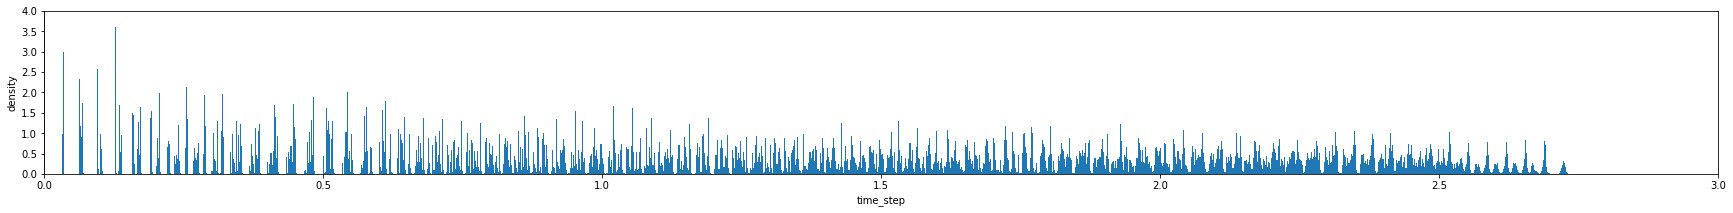

In [7]:
plot_hist(train_data.time_step, (0,4), (0,3), 'time_step')

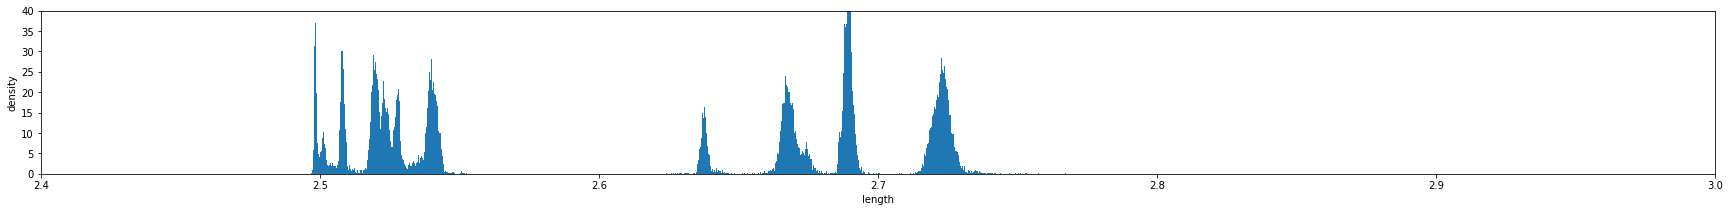

In [8]:
plot_hist(train_data.groupby("breath_id")["time_step"].max().values, (0,40), (2.4,3), 'length')

In [2]:
from data import VantilatorDataModule
from training import eval_models

In [3]:
data = VantilatorDataModule(CV_split=0)

C:\Users\codef\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|██████████| 81/81 [00:11<00:00,  7.36it/s]


series_input shape: (75450, 2, 80)
features shape: (75450, 2)


In [13]:
output, targets, inputs, features = eval_models(data)

model: 0


In [12]:
output.shape, targets.shape, inputs.shape

((15090, 80), (15090, 80), (15090, 2, 80))

In [14]:
mae = np.mean(np.abs(output - targets), axis=1)

ags = np.argsort(mae)
mae = mae[ags]

output = output[ags]
targets = targets[ags]
inputs = inputs[ags]
features = features[ags]

In [32]:
(features == [20,50]).all(axis=1).shape, np.unique(features)

((15090,), array([ 5., 10., 20., 50.], dtype=float32))

In [7]:
np.argmax(mae), mae[np.argmax(mae)], np.max(mae), np.mean(mae)

(15089, 15.888342, 15.888342, 0.79801476)

In [8]:
mae[np.argsort(mae)]

array([ 0.2128,  0.2187,  0.2346,  0.2358,  0.2374,  0.2379,  0.2409,  0.2422,  0.2431,  0.2466,  0.247 ,
        0.2487,  0.2497,  0.2516,  0.2545,  0.2565,  0.2584,  0.2591,  0.261 ,  0.2613, ...,  3.8964,
        4.0165,  4.0688,  4.0881,  4.1355,  4.1406,  4.2291,  4.2602,  4.355 ,  4.4239,  4.4813,  4.5455,
        4.5956,  4.7166,  4.7369,  4.7569,  4.8934,  5.198 ,  6.6114, 15.8883], dtype=float32)

10.0 5.0 1674
10.0 20.0 1198
10.0 50.0 2798
20.0 5.0 1651
20.0 20.0 1237
20.0 50.0 1605
50.0 5.0 1650
50.0 20.0 1657
50.0 50.0 1620


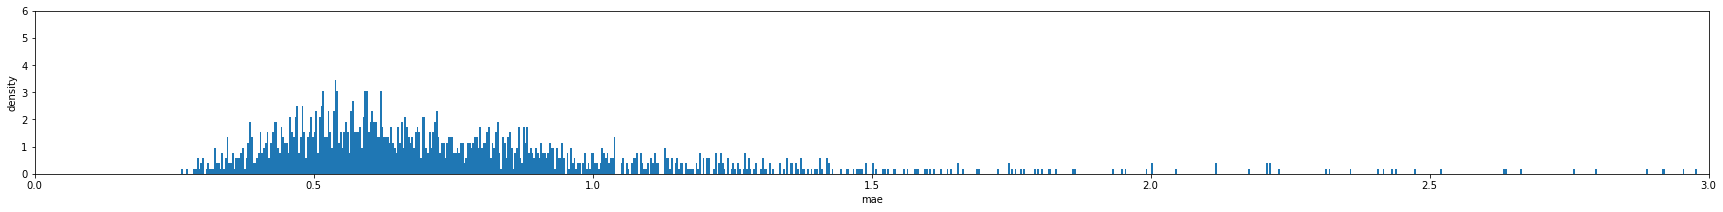

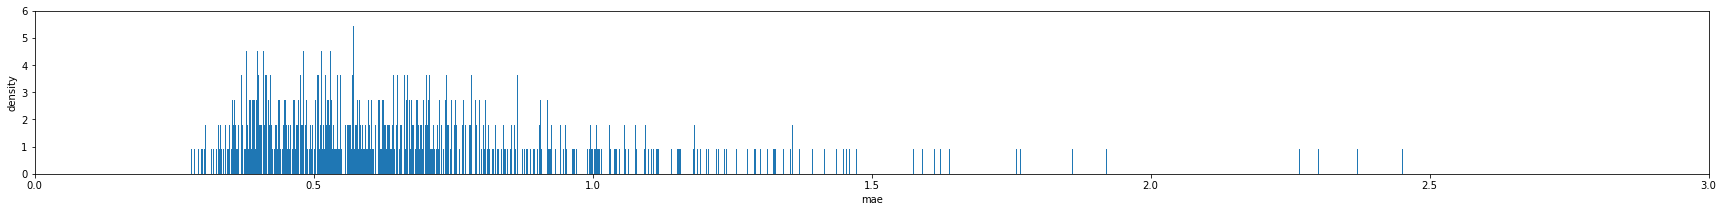

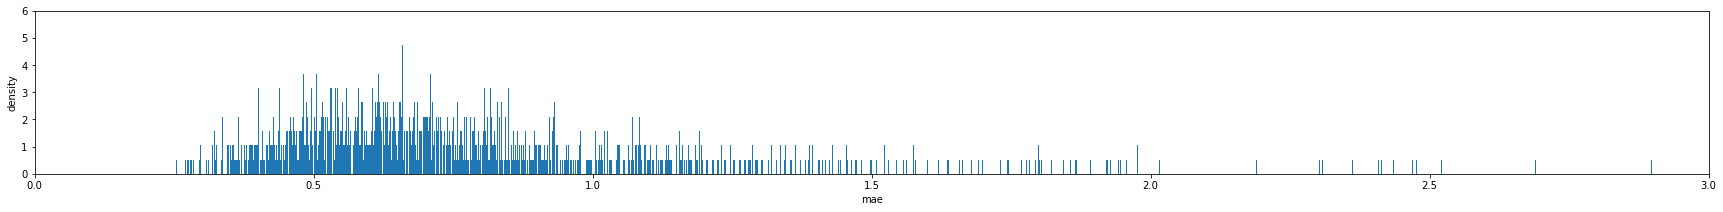

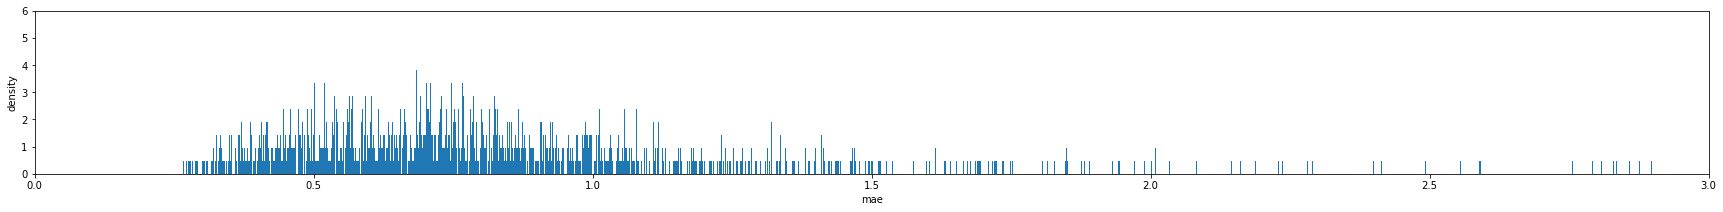

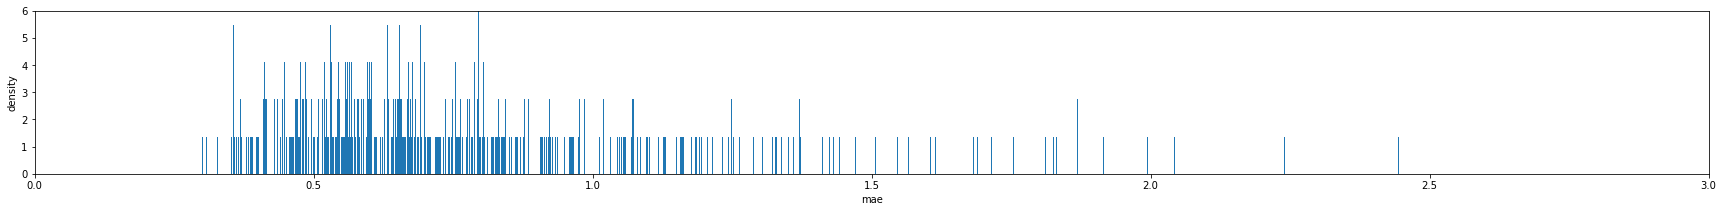

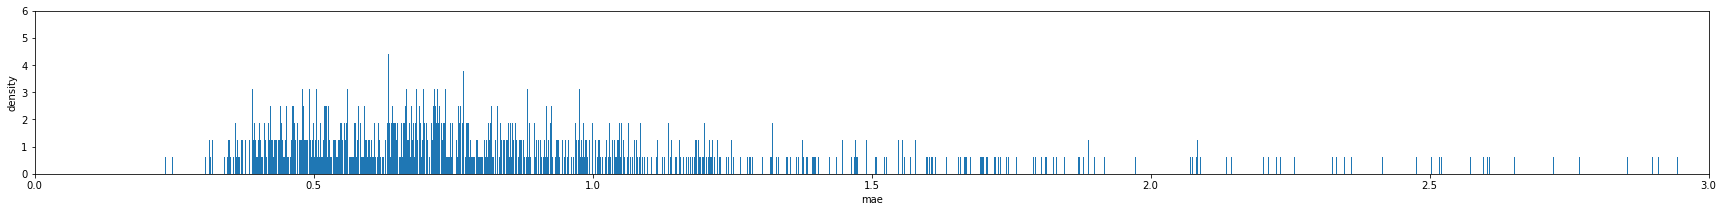

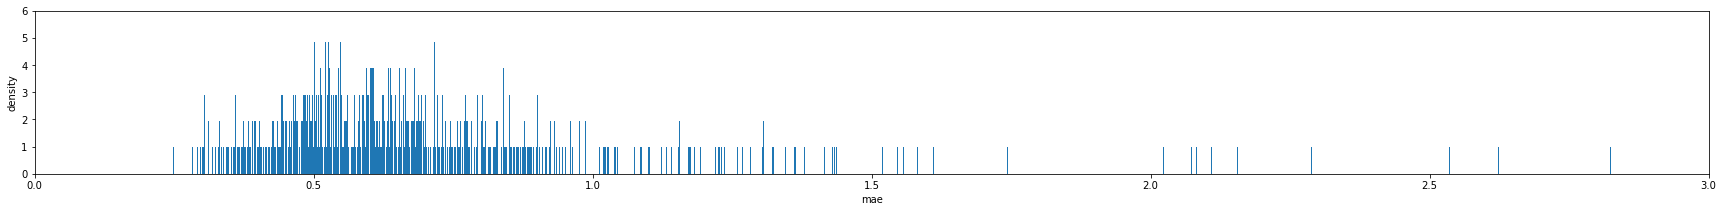

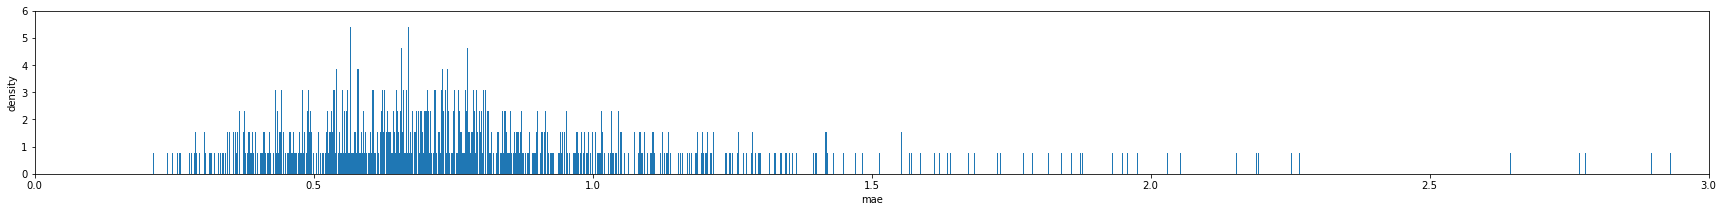

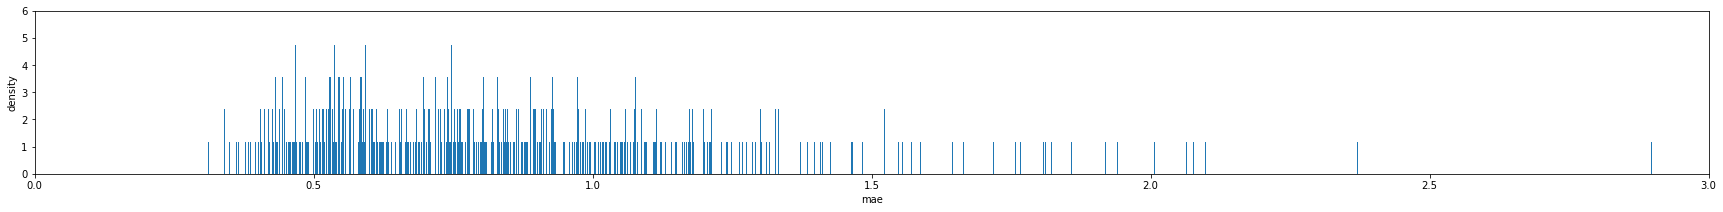

In [37]:
for e in [ 10., 20., 50.]:

    for o in [ 5., 10., 20., 50.]:

        idx = (features == [o,e]).all(axis=1)

        if idx.sum()>0:
            plot_hist(mae[idx], (0,6), (0,3), 'mae')
            print(e,o, idx.sum())

In [15]:
def plot_preassure(idx, ylim, title):

    fig, ax = plt.subplots(1,1,figsize=(20,5))

    #print(p)
    #print(list(range(80)))

    ax.plot(list(range(80)), inputs[idx,0], color='g')
    ax.plot(list(range(80)), targets[idx], color='b')
    ax.plot(list(range(80)), output[idx], color='r')
    ax.legend(features[idx], loc="upper right")
    plt.ylabel('preassure')
    plt.xlabel('time')
    #plt.ylim(ylim)

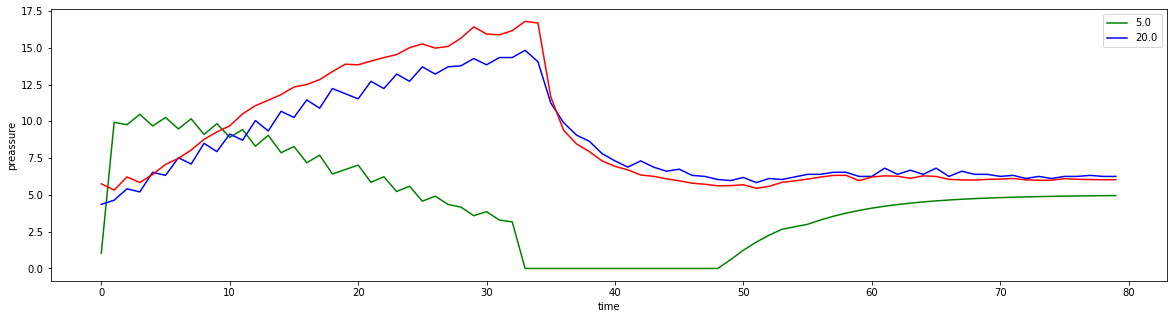

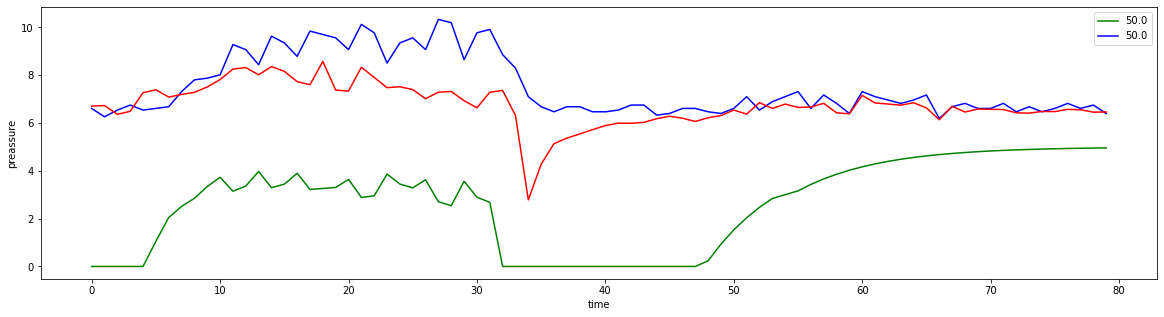

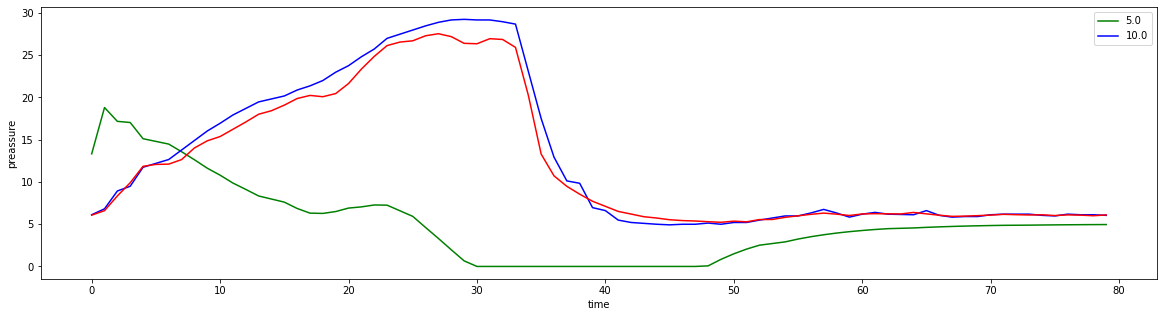

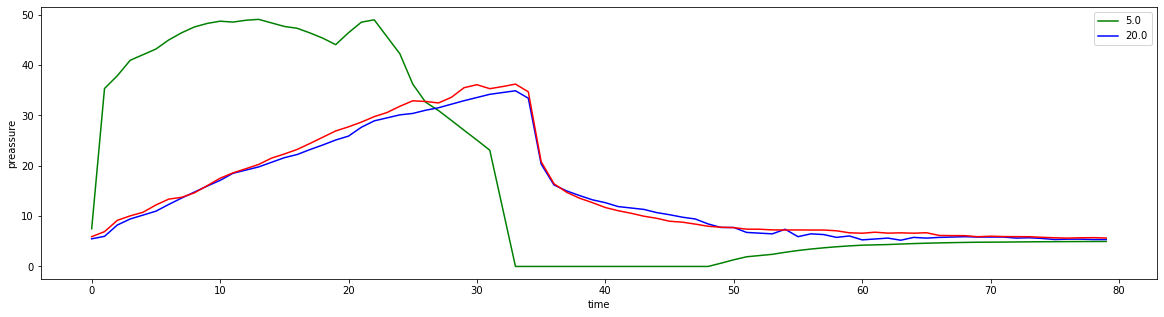

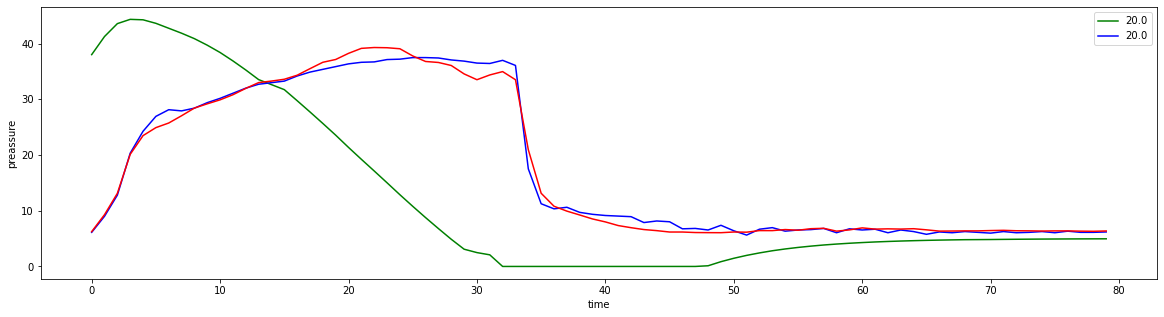

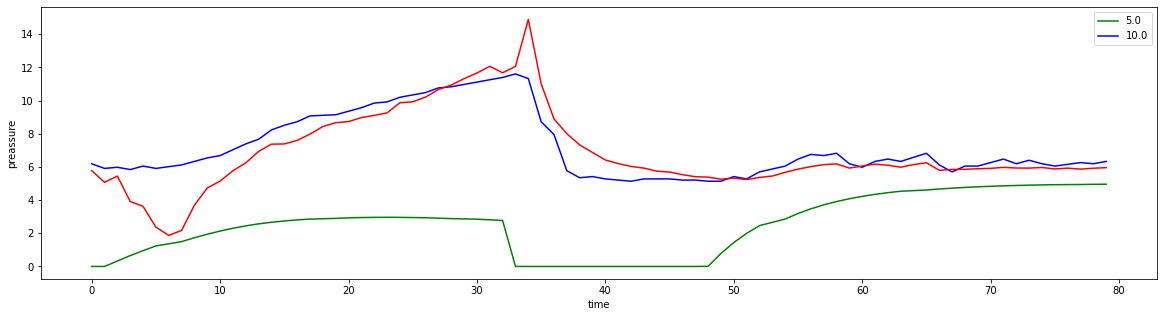

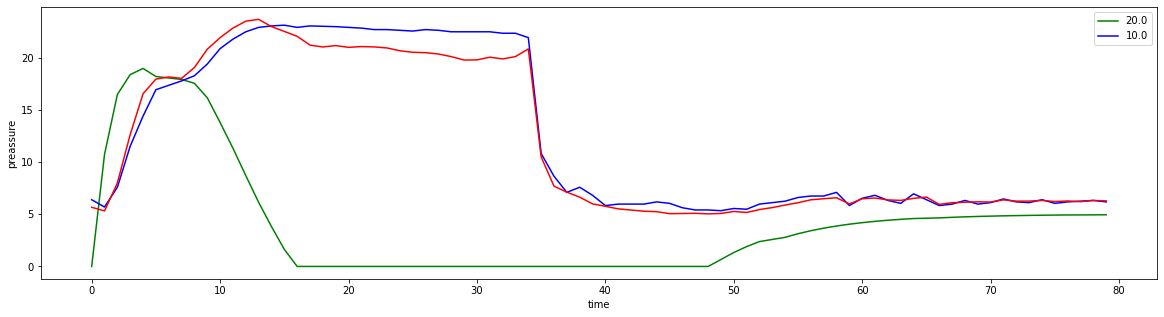

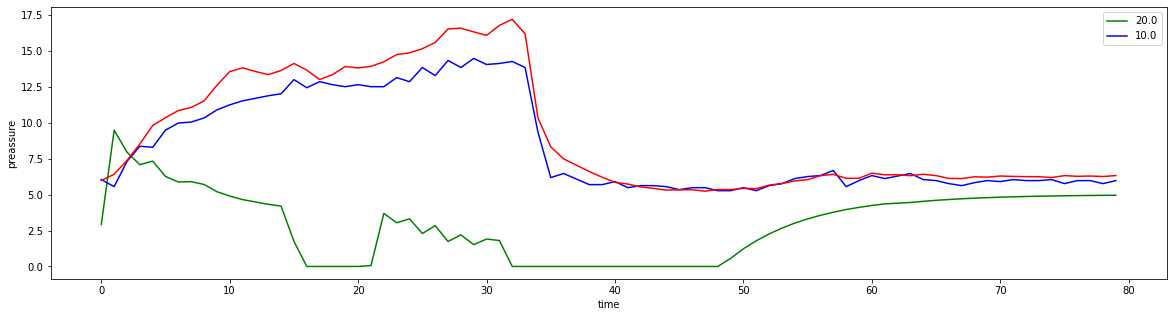

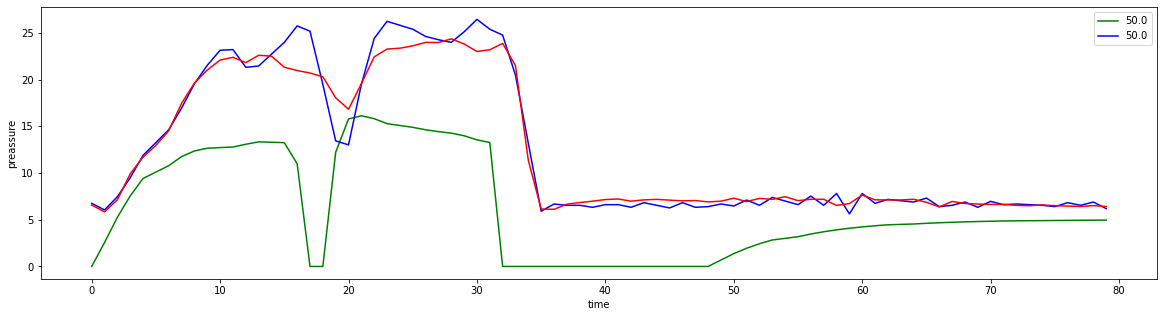

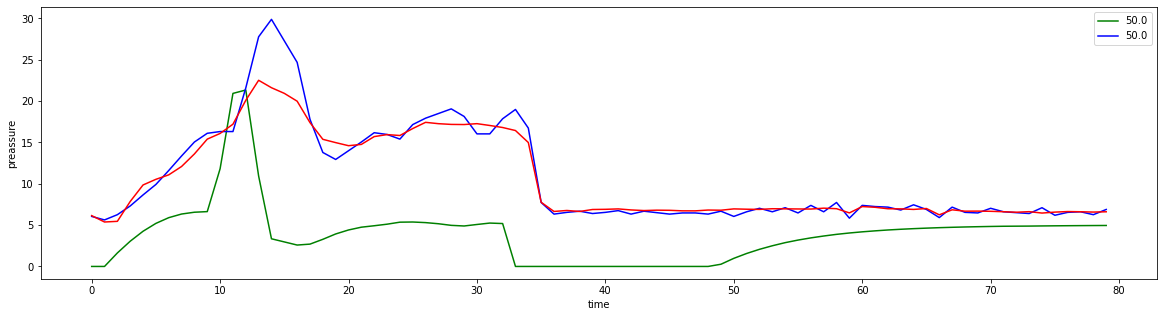

In [39]:
for i in range(10089, 10089-10, -1):
#for i in range(10):

    plot_preassure(i, (-2,2), 'title')